# LightGBM

### Установка необходимых зависимостей

In [1]:
# %pip install lightgbm

In [2]:
# %pip install optuna scikit-learn optuna-integration

In [3]:
# %pip install scipy

In [4]:
# %pip install scikit-optimize

## Импорты

In [5]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
import seaborn as sns
import joblib
import json
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from category_encoders import TargetEncoder

from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution

import warnings

warnings.filterwarnings("ignore")

from datetime import timedelta

### Определение констант

In [6]:
TARGET_NAME = 'Response'
FILE_PATH = '../data_sources/train.csv' # 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'
CV_FOLDS = 2
RANDOM_STATE = 42
N_JOBS = -1
SCORING='f1'

In [7]:
GENERAL_PARAMS = {
    "objective": "binary",
    "boosting_type": "dart",
    "random_state": RANDOM_STATE,
    "n_jobs": N_JOBS,
    "verbosity": -1,
    "is_unbalance": True,
    "metric": "average_precision",
}

In [8]:
def time_function(func):
    """Decorator to time function execution"""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"\n[{time.strftime('%H:%M:%S')}] Запуск: {func.__name__}...")
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"[{time.strftime('%H:%M:%S')}] Завершено {func.__name__} через {timedelta(seconds=int(elapsed))}")
        return result
    return wrapper

In [9]:
def show_evaluation(y_test, y_pred, y_pred_proba):
    print('Оценка модели:')
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(classification_report(y_test, y_pred))
    
    metrics = {
        'Model': 'LightGBM',
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    cm = confusion_matrix(y_test, y_pred)


    print(metrics)
    print(cm)

    sns.heatmap(
        confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues"
    )

In [10]:
class ThresholdFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01, other_name='OTHER'):
        self.threshold = threshold
        self.other_name = other_name
        self.freq_maps_ = {}
        self.columns_ = []

    def fit(self, X, y=None):
        self.columns_ = X.columns.tolist()
        
        for col in self.columns_:
            # Считаем частоты всех категорий
            value_counts = X[col].value_counts(normalize=True)
            
            # Определяем, какие категории встречаются достаточно часто
            common_categories = value_counts[value_counts >= self.threshold].index
            
            # Создаём маппинг для частотного кодирования
            freq_map = {}
            
            # Для частых категорий сохраняем их реальную частоту
            for cat in common_categories:
                freq_map[cat] = value_counts[cat]

            # Для редких категорий используем суммарную частоту
            other_categories = value_counts[value_counts < self.threshold].index
            other_freq = value_counts[other_categories].sum() if len(other_categories) > 0 else 0
            
            freq_map[self.other_name] = other_freq
            
            # Сохраняем маппинг
            self.freq_maps_[col] = freq_map
        
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        for col in self.columns_:
            if col not in X_copy.columns:
                continue
            
            # Создаём временную колонку для преобразований
            temp_col = X_copy[col].astype(str)
            
            # Группируем редкие категории в OTHER
            common_categories = list(self.freq_maps_[col].keys())
            common_categories.remove(self.other_name)
            
            # Заменяем редкие категории на OTHER
            temp_col = temp_col.where(
                temp_col.isin(common_categories), 
                other=self.other_name
            )
            
            # Применяем частотное кодирование
            encoded_values = temp_col.map(self.freq_maps_[col])
            
            # Заполняем пропуски (новые категории получают частоту OTHER)
            encoded_values = encoded_values.fillna(self.freq_maps_[col][self.other_name])
            
            # Заменяем исходную колонку
            X_copy[col] = encoded_values
        
        return X_copy

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return self.columns_
        return input_features

### Загрузка датасета

In [11]:
df = pd.read_csv(FILE_PATH, index_col='id')
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


### Применение Feature Engineering ко всему датасету

In [12]:
@time_function
def run_feature_engineering(data):
    # Соотношение признаков
    data["Age_to_Vintage"] = data["Age"] / (data["Vintage"] + 1)
    data["Premium_to_Age"] = data["Annual_Premium"] / (data["Age"] + 1)
    data["Premium_to_Vintage"] = data["Annual_Premium"] / (data["Vintage"] + 1)

    # Группировка по возрасту
    data["Age_Group"] = pd.cut(
        data["Age"], bins=[0, 25, 35, 45, 55, 100], labels=[1, 2, 3, 4, 5]
    ).astype(float)

    # Новый признак Region_Code на смену изначальным двум
    if "Region_Code" in data.columns and "Policy_Sales_Channel" in data.columns:
        data["Region_Channel"] = (
            data["Region_Code"].astype(str)
            + "_"
            + data["Policy_Sales_Channel"].astype(str)
        )

    return data

Применяем функицю feature engineering ко всему датасету

In [13]:
df = run_feature_engineering(df)
df.head()


[10:46:23] Запуск: run_feature_engineering...
[10:46:32] Завершено run_feature_engineering через 0:00:09


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Age_to_Vintage,Premium_to_Age,Premium_to_Vintage,Age_Group,Region_Channel
id,,,,,,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0,0.111702,2959.136364,346.281915,1.0,35.0_124.0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1,0.148789,1338.886364,203.844291,3.0,28.0_26.0
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0,0.098039,1463.192308,149.188235,1.0,14.0_152.0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0,0.454545,73.055556,34.155844,2.0,1.0_156.0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0,0.122034,863.540541,108.308475,3.0,15.0_152.0


Удаляем Region_Code и Policy_Sales_Channel, так как вместо него сейчас Region_Channel

In [14]:
df = df.drop(['Region_Code', 'Policy_Sales_Channel'], axis=1)

<a id="fource"></a>
### Разделение датасета

In [15]:
df_sample = df.sample(n=1500000, random_state=RANDOM_STATE)

X = df_sample.drop(TARGET_NAME, axis=1)
y = df_sample[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1000000,
    test_size=500000,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True)}")

Train shape: (1000000, 13)
Test shape: (500000, 13)
Class balance in train: Response
0    0.876795
1    0.123205
Name: proportion, dtype: float64


### Предобработка признаков

In [23]:
high_card_cols = ["Region_Channel"]
bool_cols = ["Vehicle_Damage", "Gender"]
# binary_cols = ["Vehicle_Damage"]
vehicle_age_cols = ["Vehicle_Age"]
ord_cols = ["Age_Group"]
outliers_num_cols = ["Annual_Premium"]
num_cols = [
    "Age",
    "Vintage",
    "Age_to_Vintage",
    "Premium_to_Age",
    "Premium_to_Vintage",
]


preprocessor = ColumnTransformer(

    transformers=[
        ("num", StandardScaler(), num_cols),
        (
            "outliers_num",
            RobustScaler(with_centering=True, with_scaling=True),
            outliers_num_cols,
        ),
        (
            "high_cat",
            ThresholdFrequencyEncoder(threshold=0.01, other_name="OTHER"),
            high_card_cols,
        ),
        (
            "bool",
            OneHotEncoder(drop="first", sparse_output=False, dtype=np.int32),
            bool_cols,
        ),
        (
            "vehicle_age",
            OrdinalEncoder(
                categories=[["< 1 Year", "1-2 Year", "> 2 Years"]], dtype=np.int32
            ),
            vehicle_age_cols,
        ),
        ("ord", "passthrough", ord_cols),  # Keep num features with needed order as is
        # ("binary", "passthrough", binary_cols),  # Keep binary features as is
    ],
    remainder="drop",  # Drop other columns not specified
    verbose_feature_names_out=False,
)

### RandomizedSearchCV

In [24]:
@time_function
def run_randomized_search_cv():
    model_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", lgb.LGBMClassifier(**GENERAL_PARAMS)),
        ]
    )

    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    lgb_params = {
        "classifier__num_leaves": stats.randint(15, 50),
        "classifier__max_depth": stats.randint(3, 8),
        "classifier__learning_rate": stats.loguniform(0.01, 0.2),
        "classifier__n_estimators": stats.randint(200, 500),
        "classifier__min_child_samples": stats.randint(20, 50),
        "classifier__subsample": stats.uniform(0.7, 0.3),
        "classifier__colsample_bytree": stats.uniform(0.7, 0.3),
        "classifier__reg_alpha": stats.loguniform(1e-3, 1.0),
        "classifier__reg_lambda": stats.loguniform(1e-3, 1.0),
        "classifier__min_split_gain": stats.uniform(0, 0.05),
        # dart-specific params
        "classifier__drop_rate": stats.uniform(0.05, 0.2),
        "classifier__max_drop": stats.randint(20, 100),
    }

    random_search = RandomizedSearchCV(
        estimator=model_pipeline,
        param_distributions=lgb_params,
        n_iter=15,
        cv=cv,
        scoring=SCORING,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        verbose=1,
    )

    random_search.fit(X_train, y_train)

    print("\nЛучшие параметры RandomizedSearchCV:")

    for key, value in random_search.best_params_.items():
        print(f"  {key}: {value}")
    print(f"Best CV score: {random_search.best_score_:.4f}")

    print(f"Сохранение лучших параметров RandomizedSearchCV")
    with open("best_params/best_params_light_gbm_randomized_search.json", "w") as f:
        json.dump(random_search.best_params_, f, indent=4)

    print(f"Сохранение модели с лучшими параметрами")
    joblib.dump(random_search.best_estimator_, f"models/lightgbm_random_search.pkl")

    print(f"Тренировка модели на тесте с лучшими параметрами")
    y_pred = random_search.best_estimator_.predict(X_test)
    y_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]

    return y_pred, y_pred_proba


[10:51:17] Запуск: run_randomized_search_cv...
Fitting 2 folds for each of 15 candidates, totalling 30 fits

Лучшие параметры RandomizedSearchCV:
  classifier__colsample_bytree: 0.7265477506155757
  classifier__drop_rate: 0.08919657248382905
  classifier__learning_rate: 0.011450964268326641
  classifier__max_depth: 7
  classifier__max_drop: 99
  classifier__min_child_samples: 32
  classifier__min_split_gain: 0.013567451588694796
  classifier__n_estimators: 252
  classifier__num_leaves: 38
  classifier__reg_alpha: 0.011756010900231853
  classifier__reg_lambda: 0.006963114377829284
  classifier__subsample: 0.8628088249474745
Best CV score: 0.4379
Сохранение лучших параметров RandomizedSearchCV
Сохранение модели с лучшими параметрами
Тренировка модели на тесте с лучшими параметрами
[11:04:51] Завершено run_randomized_search_cv через 0:13:33
Оценка модели:
ROC-AUC: 0.8474
              precision    recall  f1-score   support

           0       0.98      0.70      0.82    438397
         

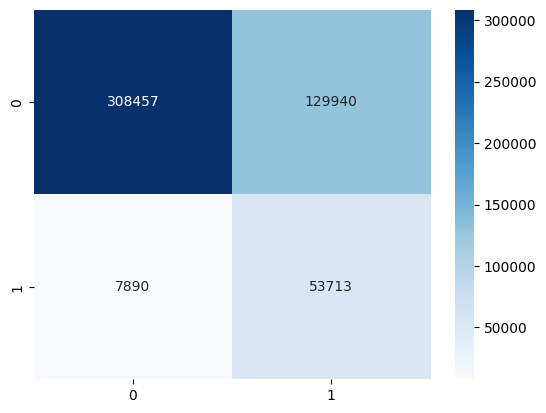

In [25]:
rscv_pred, rscv_pred_proba = run_randomized_search_cv()
show_evaluation(y_test, rscv_pred, rscv_pred_proba)

### Optuna

In [26]:
@time_function
def run_optuna_searchcv(n_trials=15):
    param_distributions = {
        "classifier__num_leaves": IntDistribution(15, 20),
        "classifier__max_depth": IntDistribution(3, 8),
        "classifier__learning_rate": FloatDistribution(0.01, 0.2),
        "classifier__n_estimators": IntDistribution(200, 500),
        "classifier__min_child_samples": IntDistribution(20, 50),
        "classifier__subsample": FloatDistribution(0.3, 0.7),
        "classifier__colsample_bytree": FloatDistribution(0.3, 0.7),
        "classifier__reg_alpha": FloatDistribution(1e-3, 1.0),
        "classifier__reg_lambda": FloatDistribution(1e-3, 1.0),
        "classifier__min_split_gain": FloatDistribution(0, 0.05),
        # Remove scale_pos_weight
        # dart-specific params
        "classifier__drop_rate": FloatDistribution(0.05, 0.2),
        "classifier__max_drop": IntDistribution(20, 100),
    }

    pipeline = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", lgb.LGBMClassifier(**GENERAL_PARAMS)),
        ]
    )

    optuna_search = OptunaSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_trials=n_trials,
        cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
        scoring=SCORING,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        verbose=1,
        enable_pruning=False,
    )

    print(f"Starting OptunaSearchCV with {n_trials} trials...")
    optuna_search.fit(X_train, y_train)

    print("\nBest parameters from OptunaSearchCV:")
    for key, value in optuna_search.best_params_.items():
        print(f"  {key}: {value}")
    print(f"Best CV score: {optuna_search.best_score_:.4f}")

    print("Сохранение лучших параметров")
    with open("best_params/best_params_ligth_gbm_optuna_searchcv.json", "w") as f:
        json.dump(optuna_search.best_params_, f, indent=4)

    print("Сохранение лучшей модели")
    joblib.dump(optuna_search.best_estimator_, "models/lightgbm_optuna_searchcv.pkl")

    print("Оценка на тестовом наборе")
    y_pred = optuna_search.predict(X_test)
    y_pred_proba = optuna_search.predict_proba(X_test)[:, 1]

    return y_pred, y_pred_proba


[11:05:46] Запуск: run_optuna_searchcv...
Starting OptunaSearchCV with 15 trials...


[I 2025-12-20 11:05:46,887] A new study created in memory with name: no-name-c6debb68-9aba-490a-aabc-934a631730f6
[I 2025-12-20 11:07:53,299] Trial 8 finished with value: 0.42672092854586285 and parameters: {'classifier__num_leaves': 16, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.14632280368871792, 'classifier__n_estimators': 203, 'classifier__min_child_samples': 30, 'classifier__subsample': 0.5803459425388608, 'classifier__colsample_bytree': 0.5265151905572087, 'classifier__reg_alpha': 0.730924288911111, 'classifier__reg_lambda': 0.7340422373654509, 'classifier__min_split_gain': 0.021118685444194554, 'classifier__drop_rate': 0.11737737372246185, 'classifier__max_drop': 83}. Best is trial 8 with value: 0.42672092854586285.
[I 2025-12-20 11:08:36,232] Trial 4 finished with value: 0.42697868725598365 and parameters: {'classifier__num_leaves': 18, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.040431431274967414, 'classifier__n_estimators': 223, 'classifier__mi


Best parameters from OptunaSearchCV:
  classifier__num_leaves: 20
  classifier__max_depth: 5
  classifier__learning_rate: 0.07418589895965191
  classifier__n_estimators: 411
  classifier__min_child_samples: 44
  classifier__subsample: 0.44306621485281855
  classifier__colsample_bytree: 0.3070041758580809
  classifier__reg_alpha: 0.28904608859234615
  classifier__reg_lambda: 0.5768342222201367
  classifier__min_split_gain: 0.04276818670859794
  classifier__drop_rate: 0.14712906669815418
  classifier__max_drop: 71
Best CV score: 0.4341
Сохранение лучших параметров
Сохранение лучшей модели
Оценка на тестовом наборе
[11:17:45] Завершено run_optuna_searchcv через 0:11:59
Оценка модели:
ROC-AUC: 0.8518
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    438397
           1       0.29      0.90      0.43     61603

    accuracy                           0.71    500000
   macro avg       0.63      0.79      0.62    500000
weighted avg       0.

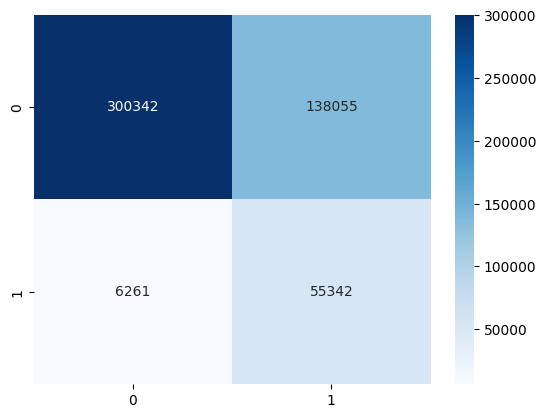

In [27]:
optuna_pred, optuna_pred_proba = run_optuna_searchcv()
show_evaluation(y_test, optuna_pred, optuna_pred_proba)